# Build A Basic Chatbot With Langgraph(GRAPH API)

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict): # state class will return a TypedDict which is a dictionary with specific keys and value types
    # Insidez the state class we define the structure of the state that will be used in the graph
    # here it is a TypedDict with a single key "messages" which is a list, then we define structure of key i.e messages
    # messages is a list that will be updated with new messages that are send by the user
    messages:Annotated[list,add_messages] # messages is a list that will be updated with new messages that are send by the user or the bot  
    # Annotated is used to specify that the messages key will be updated by the add_messages function
    # The add_messages function is a utility that appends new messages to the existing list of messages instead of replacing it
    
graph_builder = StateGraph(State) # StateGraph is a class that builds a state graph with the given state type, it takes the State class as an argument
# the state class is used to define the structure of the state that will be used in the graph, here it is a TypedDict with a single key "messages" which is a 
# list that will be updated with new messages

- StateGraph is a class or a function that constructs a graph of computational nodes (steps) where each node operates on and passes around a shared state.
- When you call StateGraph(State), you're saying:
- `I want to build a graph-based workflow where each node works with a state of type State.`
- So StateGraph(State): Initializes a graph-building context.
- Each node in this graph will receive the state dictionary (with a messages key) as input and return updates to it.
- The add_messages function (used via Annotated) tells the framework how to update the messages list (by appending to it, not overwriting it).

In [3]:
graph_builder

- graph_builder :
    - This becomes your "graph construction toolkit" — an object that allows you to:
    - Add nodes (functions like your chatbot(state)) using graph_builder.add_node(...).
    - Define the flow of how data (state) moves between nodes.
    - Connect nodes to say: "First run nodeA, then send its output into nodeB."
    - Compile and run the full graph.

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001CC2B40C860>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001CC2CA092E0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
## Node Functionality 
def chatbot(state:State): # This function defines the chatbot's behavior, it takes the current state as an argument, current state has all the messages that 
    # have been sent so far and state is of type State which is a TypedDict with a single key "messages" which is a list that will be updated with new messages
    # The function will return a response that will be appended to the messages list in the state
    return {"messages":[llm.invoke(state["messages"])]} # 

- Whenever we input a message it is given to chatbot function, which invokes the LLM with the all the messages in the conversation so far, the llm.invoke function takes the list of messages and returns a response from the LLM messages and returns a response that is appended to the messages list in the state, state["messages"] gives access to key "messages" in the state dictionary and this key messages is a list that will be updated with new messages that are send by the user or the bot

In [8]:
graph_builder=StateGraph(State) # defining the graph builder again to ensure it is fresh and ready to use

## Adding node
graph_builder.add_node("llmchatbot",chatbot) # This adds a node to the graph with the name "llmchatbot" and the function chatbot as its node definition.    
## Adding Edges
graph_builder.add_edge(START,"llmchatbot") # This connects the START node to the "llmchatbot" node, meaning the graph will start execution from this node
graph_builder.add_edge("llmchatbot",END) # This connects the "llmchatbot" node to the END node, meaning the graph will end execution after this node

## compile the graph
graph=graph_builder.compile() # This compiles the graph, making it ready for execution. The graph now has a single node "llmchatbot" that will be executed when the graph is run.

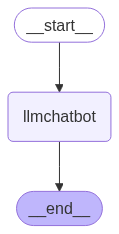

In [9]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response=graph.invoke({"messages":"Hi"}) # As llmchatbot node takes a state as input, we need to pass a state dictionary with a key "messages" which is list
# we are passing a string "Hi" as the first message in the conversation, this will be appended to the messages list in the state and passed to the llm.invoke function

In [11]:
response["messages"][-1].content # The response is a dictionary with a key "messages" which is a list of messages, we are getting the last message in the 
# list which is the response from the LLM

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
for event in graph.stream({"messages":"Hi How are you?"}): # This will stream the response from the LLM, it will print the last message in the conversation 
    # after each event i.e after each message is generated by the LLM
    for value in event.values():
        print(value["messages"][-1].content)

I'm just an AI, so I don't have emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you have! It's great to chat with you. How can I assist you today?


## Tools with LangGraph
- LangGraph allows you to define tools that can be used in the graph

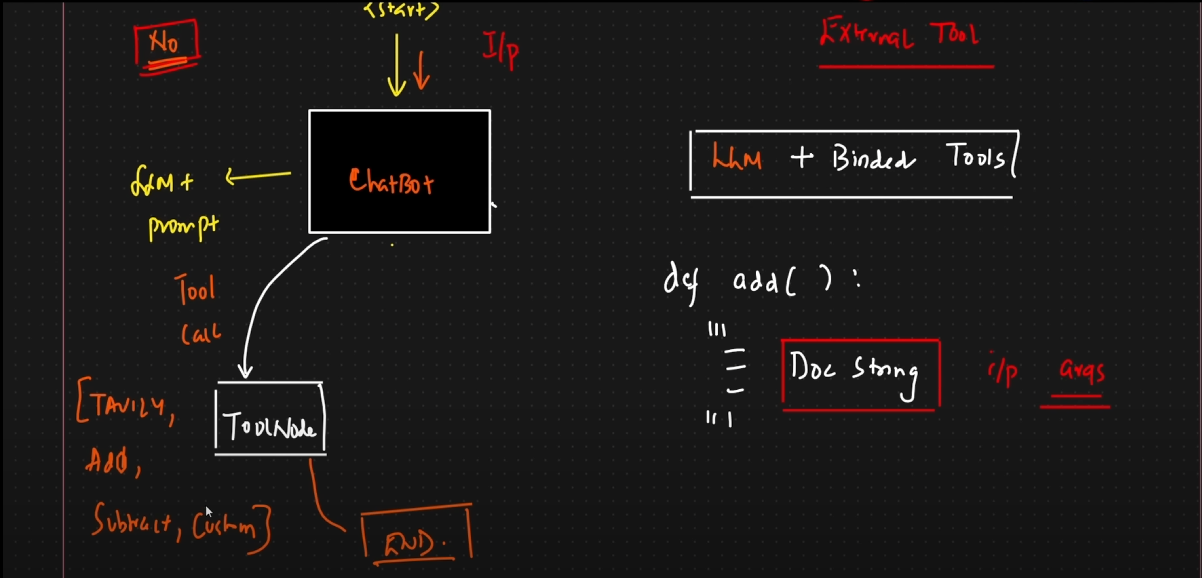

- These tools can be binded with llm itself as only llm may not have all info like current time, weather, news, etc. So the tools can be used to fetch that info and then pass it to the llm to generate a response whenever llm feels it is needed.
- So whenever a question is asked the tool_llm node decides whether it can answer the question or it needs to use a tool to fetch the info and then generate a response. This decision is made using doc_string of tool which is a string that descibes the tool and its usage, this doc_string is used by the llm to understand what the tool does and how it can be used to answer the question.

In [13]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is langgraph")

{'query': 'What is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What is LangGraph? - IBM',
   'url': 'https://www.ibm.com/think/topics/langgraph',
   'content': 'LangGraph, created by LangChain, is an open source AI agent framework designed to build, deploy and manage complex generative AI agent workflows. At its core, LangGraph uses the power of graph-based architectures to model and manage the intricate relationships between various components of an AI agent workflow. LangGraph illuminates the processes within an AI workflow, allowing full transparency of the agent’s state. By combining these technologies with a set of APIs and tools, LangGraph provides users with a versatile platform for developing AI solutions and workflows including chatbots, state graphs and other agent-based systems. Nodes: In LangGraph, nodes represent individual components or agents within an AI workflow. LangGraph uses enhanced decision-making by modeling c